# Library Imports

In [19]:
import pandas as pd
import glob
import requests
import time

In [20]:
import seaborn as sns

# Data Imports / Exports

In [23]:
# THESE FILES ARE EXCLUDED FROM THE REPOSITORY
stream_json = glob.glob('datasets/v2/Streaming_History_Audio*.json')

In [24]:
# see the list of globbed files
stream_json

['datasets/v2\\Streaming_History_Audio_2016-2017_0.json',
 'datasets/v2\\Streaming_History_Audio_2017-2018_1.json',
 'datasets/v2\\Streaming_History_Audio_2018-2019_2.json',
 'datasets/v2\\Streaming_History_Audio_2019-2020_3.json',
 'datasets/v2\\Streaming_History_Audio_2020-2021_4.json',
 'datasets/v2\\Streaming_History_Audio_2021-2022_5.json',
 'datasets/v2\\Streaming_History_Audio_2022-2023_6.json',
 'datasets/v2\\Streaming_History_Audio_2023_7.json',
 'datasets/v2\\Streaming_History_Audio_2023_8.json']

In [25]:
# load the globbed files into a dataframe
stream_df = pd.concat([pd.read_json(f) for f in stream_json])

In [3]:
tracks_df = pd.read_csv('datasets/tracks_df.csv')
podcasts_df = pd.read_csv('datasets/podcasts_df.csv')

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\2056156176.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv('datasets/tracks_df.csv')


# Preparing for Data Collection
we need 4 things here.
1. tracks streaming history
2. podcasts streaming history
3. list of unique tracks streamed
4. ~~list of unique podcasts streamed~~ not really needed actually

In [26]:
print(stream_df.shape)
print(stream_df.columns)

(130209, 21)
Index(['ts', 'username', 'platform', 'ms_played', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')


In [27]:
stream_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130209 entries, 0 to 2979
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 130209 non-null  object
 1   username                           130209 non-null  object
 2   platform                           130209 non-null  object
 3   ms_played                          130209 non-null  int64 
 4   conn_country                       130209 non-null  object
 5   ip_addr_decrypted                  109601 non-null  object
 6   user_agent_decrypted               109601 non-null  object
 7   master_metadata_track_name         129393 non-null  object
 8   master_metadata_album_artist_name  129393 non-null  object
 9   master_metadata_album_album_name   129393 non-null  object
 10  spotify_track_uri                  129393 non-null  object
 11  episode_name                       641 non-null     object


In [28]:
# number of unique values in each column
stream_df.nunique()

ts                                   122712
username                                  1
platform                                 33
ms_played                             27030
conn_country                              9
ip_addr_decrypted                      2750
user_agent_decrypted                      6
master_metadata_track_name             4783
master_metadata_album_artist_name      1646
master_metadata_album_album_name       2700
spotify_track_uri                      5245
episode_name                            297
episode_show_name                        31
spotify_episode_uri                     297
reason_start                              8
reason_end                               10
shuffle                                   2
skipped                                   2
offline                                   2
offline_timestamp                    128332
incognito_mode                            2
dtype: int64

In [29]:
stream_df.isna().sum()

ts                                        0
username                                  0
platform                                  0
ms_played                                 0
conn_country                              0
ip_addr_decrypted                     20608
user_agent_decrypted                  20608
master_metadata_track_name              816
master_metadata_album_artist_name       816
master_metadata_album_album_name        816
spotify_track_uri                       816
episode_name                         129568
episode_show_name                    129568
spotify_episode_uri                  129568
reason_start                              0
reason_end                            20608
shuffle                                   0
skipped                              106195
offline                                   0
offline_timestamp                         0
incognito_mode                            0
dtype: int64

In [30]:
stream_df['user_agent_decrypted'].value_counts()

user_agent_decrypted
unknown                                                                                                                                                                  109525
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64)%20AppleWebKit%2F537.36%20(KHTML,%20like%20Gecko)%20Chrome%2F95.0.4638.54%20Safari%2F537.36%20Edg%2F95.0.1020.40        66
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:84.0)%20Gecko%2F20100101%20Firefox%2F84.0                                                                          6
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:61.0)%20Gecko%2F20100101%20Firefox%2F61.0                                                                          2
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:69.0)%20Gecko%2F20100101%20Firefox%2F69.0                                                                          1
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:83.0)%20Gecko%2F20100101%20Firefox%2F83.

In [31]:
# dropping some columns that might cnotain sensitive information or just not useful
stream_df.drop(columns=['username', 'ip_addr_decrypted', 'user_agent_decrypted'], inplace=True)

there are a huge number of null value of 'spotify_episode_uri', indicating that tracks/songs and podcasts don't share same uri, we need to separate this into its own dataframe (for tracks and podcasts)

In [32]:
# rows with null in both spotify_track_uri and spotify_episode_uri
print(stream_df[stream_df['spotify_episode_uri'].isna() & stream_df['spotify_track_uri'].isna()].shape)
print(stream_df[stream_df['spotify_episode_uri'].notna() & stream_df['spotify_track_uri'].notna()].shape)

(175, 18)
(0, 18)


so apparently there exists some rows are null on both spotify_episode_uri and spotify_track_uri, so those should be excluded as well

In [33]:
# get rows with null values in 'spotify_episode_uri' column and put it into a new dataframe
tracks_df = stream_df[stream_df['spotify_track_uri'].notna()]
podcasts_df = stream_df[stream_df['spotify_episode_uri'].notna()]

In [34]:
print(tracks_df.shape)
print(podcasts_df.shape)

(129393, 18)
(641, 18)


In [35]:
# list of tracks, containing unique values in 'spotify_track_uri' column
tracks_uri_list = tracks_df['spotify_track_uri'].unique().tolist()
podcasts_uri_list = podcasts_df['spotify_episode_uri'].unique().tolist()

In [36]:
print(len(tracks_uri_list))
print(len(podcasts_uri_list))

5245
297


In [37]:
# save tracks_df and podcasts_df into csv
tracks_df.to_csv('datasets/tracks_df.csv', index=False)
podcasts_df.to_csv('datasets/podcasts_df.csv', index=False)

# Data Collection (Spotipy)
now we're going to collect the using [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/), it'll require user credentials (client_id and client_secret) which you can get [here](https://developer.spotify.com/dashboard) by registering your app at the dashboard

In [38]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [72]:
# Spotify API credentials (client_id and client_secret used will be excluded from the repository)
client_id = 'INSERT CLIENT ID HERE'
client_secret = 'INSERT CLIENT SECRET HERE'

In [40]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## get track info

In [41]:
# since they have the batch request limit of 50, we need to split the list into batches of 50
track_info = {}
for i in range(0, len(tracks_uri_list), 50):
    track_batch = tracks_uri_list[i:i+50]
    sapi = sp.tracks(track_batch)
    for track in sapi['tracks']:
        track_info[track['id']] = {'name':track['name'], 'artistName':track['artists'][0]['name'], 'release_date':track['album']['release_date'], 'popularity':track['popularity'], 'duration_ms':track['duration_ms']}
    time.sleep(1)
    

In [42]:
len(track_info)

5245

In [43]:
list(track_info.items())[:5]

[('6tAM5c0bJOwRqGAEgiNMpI',
  {'name': 'Solace Album Mix',
   'artistName': 'Monstercat',
   'release_date': '2012-06-06',
   'popularity': 0,
   'duration_ms': 3538579}),
 ('4mjgNE8R31AzxWfPNGtVMf',
  {'name': 'Best of 2015 (Album Mix)',
   'artistName': 'Monstercat',
   'release_date': '2016-01-22',
   'popularity': 0,
   'duration_ms': 9158194}),
 ('5Q0P0cX3e42PgKd8LLS3ms',
  {'name': 'Horizon Album Mix',
   'artistName': 'Monstercat',
   'release_date': '2014-08-06',
   'popularity': 0,
   'duration_ms': 3623121}),
 ('6jvMmRtSzoEibQGrQkSISQ',
  {'name': 'Monstercat Best of 2012',
   'artistName': 'Monstercat',
   'release_date': '2013-02-04',
   'popularity': 0,
   'duration_ms': 6348017}),
 ('1KzLyjpjIRHuuj4iX8QsC2',
  {'name': 'Monstercat Podcast EP. 100',
   'artistName': 'Monstercat',
   'release_date': '2016-04-05',
   'popularity': 0,
   'duration_ms': 9744610})]

In [44]:
track_info_df = pd.DataFrame.from_dict(track_info, orient='index')

In [45]:
track_info_df.to_csv('datasets/tracks_info_df.csv')

## get track features

In [46]:
track_features = {}
for i in range(0, len(tracks_uri_list), 50):
    track_batch = tracks_uri_list[i:i+50]
    sapi = sp.audio_features(track_batch)
    for track in sapi:
        if track is not None:
            track_features[track['id']] = {'danceability':track['danceability'], 'energy':track['energy'], 'key':track['key'], 'loudness':track['loudness'], 'mode':track['mode'], 'speechiness':track['speechiness'], 'acousticness':track['acousticness'], 'instrumentalness':track['instrumentalness'], 'liveness':track['liveness'], 'valence':track['valence'], 'tempo':track['tempo'], 'time_signature':track['time_signature']}
        # we'll skip it if the track has no audio features data
    time.sleep(1)

In [47]:
len(track_features)

5238

In [48]:
# get first 5 items in the dictionary
list(track_features.items())[:5]

[('6tAM5c0bJOwRqGAEgiNMpI',
  {'danceability': 0.446,
   'energy': 0.823,
   'key': 11,
   'loudness': -5.279,
   'mode': 0,
   'speechiness': 0.0859,
   'acousticness': 0.00256,
   'instrumentalness': 0.0748,
   'liveness': 0.117,
   'valence': 0.263,
   'tempo': 128.198,
   'time_signature': 4}),
 ('5Q0P0cX3e42PgKd8LLS3ms',
  {'danceability': 0.402,
   'energy': 0.856,
   'key': 1,
   'loudness': -4.256,
   'mode': 1,
   'speechiness': 0.0659,
   'acousticness': 0.00504,
   'instrumentalness': 0.0164,
   'liveness': 0.253,
   'valence': 0.247,
   'tempo': 140.028,
   'time_signature': 4}),
 ('4VrdksXJVhAOLW49qV0VTQ',
  {'danceability': 0.426,
   'energy': 0.915,
   'key': 11,
   'loudness': -3.881,
   'mode': 0,
   'speechiness': 0.143,
   'acousticness': 0.000899,
   'instrumentalness': 0.108,
   'liveness': 0.495,
   'valence': 0.271,
   'tempo': 130.405,
   'time_signature': 4}),
 ('0ng42pTjKgskmobNzhnEUa',
  {'danceability': 0.434,
   'energy': 0.839,
   'key': 8,
   'loudness': 

In [49]:
track_features_df = pd.DataFrame.from_dict(track_features, orient='index')
track_features_df.to_csv('datasets/tracks_features_df.csv')

# Tracks Streaming Data

## Data Exploration / EDA

In [172]:
# let's load the tracks_df again
tracks_df = pd.read_csv('datasets/tracks_df.csv')
tracks_df.sample(5)

C:\Users\Kim\AppData\Local\Temp\ipykernel_14320\4189168743.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv('datasets/tracks_df.csv')


,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
116162,2023-05-02T03:58:50Z,android,267300,JP,Sick of Losing Soulmates,dodie,Intertwined - EP,spotify:track:7a9udNo0GU97xnMAkjLdmE,NaN,NaN,NaN,trackdone,trackdone,True,False,False,1682999662,False
95640,2022-05-30T08:35:40Z,"Android OS 11 API 30 (OnePlus, HD1910)",5048,JP,おもかげ (produced by Vaundy),milet,おもかげ (produced by Vaundy),spotify:track:6ts1KCOudfDYXYfyWtq0k1,NaN,NaN,NaN,trackdone,backbtn,False,NaN,False,1653899732733,False
3438,2017-03-26T21:06:11Z,Windows 10 (10.0.10586; x64),178124,ID,"Swordland (From ""Sword Art Online"")",Taylor Davis,"Swordland (From ""Sword Art Online"")",spotify:track:1IbqahgWSIgMcgUxbupT19,NaN,NaN,NaN,trackdone,NaN,False,NaN,False,1490562191806,False
35760,2018-12-12T08:00:55Z,Windows 10 (10.0.17134; x64),198693,JP,Dream - Acoustic,Bishop Briggs,Dream,spotify:track:67l1tytshju3Ily8uIAVKH,NaN,NaN,NaN,trackdone,trackdone,True,NaN,False,1544601453776,False
55510,2020-02-03T10:00:36Z,Windows 10 (10.0.18362; x64; AppX),189346,JP,Wild Horses,Bishop Briggs,Bishop Briggs,spotify:track:0XyeD5XgusMHQlEVlUfxSn,NaN,NaN,NaN,trackdone,trackdone,True,NaN,False,1580723846279,False


In [51]:
print(tracks_df.shape)
print(tracks_df.columns)

(129393, 18)
Index(['ts', 'platform', 'ms_played', 'conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')


In [52]:
# let's take a look at the tracks_df again
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129393 entries, 0 to 2979
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 129393 non-null  object
 1   platform                           129393 non-null  object
 2   ms_played                          129393 non-null  int64 
 3   conn_country                       129393 non-null  object
 4   master_metadata_track_name         129393 non-null  object
 5   master_metadata_album_artist_name  129393 non-null  object
 6   master_metadata_album_album_name   129393 non-null  object
 7   spotify_track_uri                  129393 non-null  object
 8   episode_name                       0 non-null       object
 9   episode_show_name                  0 non-null       object
 10  spotify_episode_uri                0 non-null       object
 11  reason_start                       129393 non-null  object


Columns description
- ts : timestamp played
- ms_played : duration the track is played (ms)
- conn_country : country where the track was played
- master_metadata_track_name / artist_name / album_name : self explained
- spotify_track_uri : unique identifier for each track
- episode_name, episode_show_name, spotify_episode_uri : columns used for podcasts-related rows, might need to remove this later
- reason_start / end : a value telling why track is played
- shuffle / skipped / offline / incognito_mode : value whether the track if shuffle mode is used when the track is played, track skipped or when the track is played in offline mode or incognito_mode
- offline_timestamp : timestamp when the offline mode is used

In [53]:
# checking the number of unique from each column
tracks_df.nunique()

ts                                   121914
platform                                 32
ms_played                             26468
conn_country                              9
master_metadata_track_name             4783
master_metadata_album_artist_name      1646
master_metadata_album_album_name       2700
spotify_track_uri                      5245
episode_name                              0
episode_show_name                         0
spotify_episode_uri                       0
reason_start                              8
reason_end                               10
shuffle                                   2
skipped                                   2
offline                                   2
offline_timestamp                    127519
incognito_mode                            2
dtype: int64

In [54]:
# descriptive analysis for categorical data
tracks_df.describe(include='object')

,ts,platform,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,skipped
count,129393,129393,129393,129393,129393,129393,129393,0,0,0,129393,108855,23972.0
unique,121914,32,9,4783,1646,2700,5245,0,0,0,8,10,2.0
top,2019-06-28T06:57:01Z,"Android OS 11 API 30 (OnePlus, HD1910)",JP,Interdimensional Portal Leading to a Cute Plac...,In Love With a Ghost,Church Of Scars,spotify:track:1HW1arhhmKY3jI7QyARvsf,NaN,NaN,NaN,trackdone,trackdone,0.0
freq,208,21563,103209,762,11074,3173,762,NaN,NaN,NaN,96588,82153,21056.0


In [55]:
# descriptive analysis for numerical data
tracks_df.describe()

,ms_played,offline_timestamp
count,1.293930e+05,1.293930e+05
mean,1.569280e+05,1.268591e+12
std,9.212008e+04,6.274175e+11
min,0.000000e+00,0.000000e+00
25%,9.120000e+04,1.498709e+12
50%,1.829730e+05,1.551874e+12
75%,2.162130e+05,1.610864e+12
max,1.082813e+06,1.665763e+12


<Axes: xlabel='ms_played', ylabel='Count'>

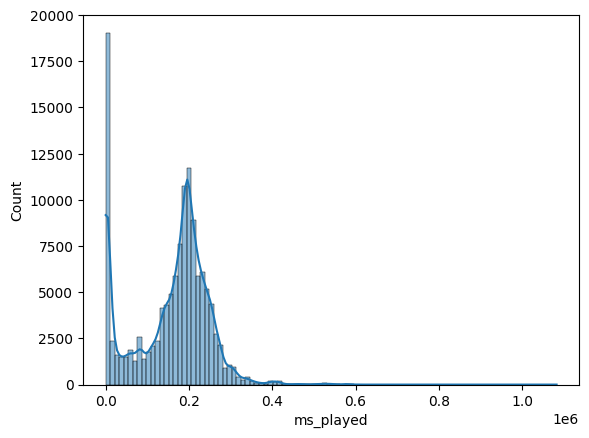

In [56]:
# histogram for ms_played rounded to nearest 1000 (in seconds) to see the distribution
sns.histplot(tracks_df['ms_played'].round(-3), kde = True, bins=100)

In [57]:
display(tracks_df[tracks_df['ms_played'] == 0].sample(5))
print(tracks_df[tracks_df['ms_played'] == 0].shape)

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
1777,2021-07-22T07:48:48Z,"Android OS 10 API 29 (OnePlus, ONEPLUS A5010)",0,JP,Nothing's Real,Shura,Nothing's Real,spotify:track:7xTLGXEvVlTu0ugHJyaFAs,None,None,None,backbtn,backbtn,False,NaN,False,1626940128709,False
15278,2018-10-03T06:17:23Z,"Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)",0,ID,Forbidden Codex,Hoskey,"Chapter K (From ""Cytus"")",spotify:track:6vI9b0UZMbje1SHlIEir5Z,None,None,None,backbtn,backbtn,False,NaN,False,1538547441859,False
35,2017-12-15T13:54:26Z,Windows 10 (10.0.14393; x64),0,ID,Why,ayaka,Sing to the Sky,spotify:track:21qxrmTwQkOF5MivDaMvuX,None,None,None,clickrow,None,True,NaN,False,1513305026857,False
2018,2017-03-05T04:08:27Z,Windows 10 (10.0.14393; x64),0,ID,I'm Beginning To Think You Prefer Beverly Hill...,Fight Like Apes,Fight Like Apes and The Mystery of The Golden ...,spotify:track:0SxZpiF1BfbLiKJAamelYz,NaN,NaN,NaN,trackdone,None,True,NaN,False,1488653178484,False
9274,2020-03-05T12:29:37Z,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",0,ID,Lyin',Bishop Briggs,Church Of Scars,spotify:track:3Xq94gH5xsWHSBAdfG8GaO,None,None,None,fwdbtn,fwdbtn,True,NaN,False,1583411373848,False


(3759, 18)


there are surprisingly a lot of rows with 0 ms_played, might need to check it later

In [58]:
# checking platform unique values
tracks_df['platform'].value_counts()

platform
Android OS 11 API 30 (OnePlus, HD1910)                       21563
android                                                      20780
Android OS 9 API 28 (OnePlus, ONEPLUS A5010)                 15578
Android OS 10 API 29 (OnePlus, ONEPLUS A5010)                15124
Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)             10919
Windows 10 (10.0.17134; x64)                                  7099
Android OS 7.1.1 API 25 (Sony, E6683)                         6847
Windows 10 (10.0.14393; x64)                                  6764
Windows 10 (10.0.18363; x64)                                  6702
Android OS 7.0 API 24 (Sony, E6683)                           4074
windows                                                       3192
Windows 10 (10.0.18362; x64)                                  2858
Android OS 8.0.0 API 26 (OnePlus, ONEPLUS A5010)              1049
Windows 10 (10.0.16299; x64)                                  1011
Android OS 6.0.1 API 23 (Sony, E6683)                

in hindsight, it seems there are just 3 unique values in platform column (android, windows, web_player), we need to handle this value

based on what we've seen, there are some things that we need to handle:
- drop podcasts related columns
- drop offline_timestamp column
- ~~drop conn_country column since I think what _platform_ the track was streamed is more important than the _country_ it was streamed~~
- drop incognito_mode column
- convert 'ts' column into datetime datatype
- rename columns with long label (master_metadata_artist_name, etc) into shorter form
- trim spotify_track_uri to only track ids
- handle _platform_ into three values (web_player, android, windows)
- take a look on rows with 0 ms_played 

## Data Preprocessing

### dropping unimportant columns

In [68]:
# dropping the columns that are not useful
tracks_df.drop(columns=['offline_timestamp', 'episode_name', 'episode_show_name', 'spotify_episode_uri'], inplace=True)


C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\1729471834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df.drop(columns=['offline_timestamp', 'episode_name', 'episode_show_name', 'spotify_episode_uri'], inplace=True)


In [69]:
tracks_df.drop(columns=['incognito_mode'], inplace=True)

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\3684800831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df.drop(columns=['incognito_mode'], inplace=True)


### converting 'ts' column to datetime datatype

In [67]:
# converting 'ts' to datetime format
tracks_df['ts'] = pd.to_datetime(tracks_df['ts'])

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\3193864608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df['ts'] = pd.to_datetime(tracks_df['ts'])


### renaming columns with long label

In [65]:
# renaming master_metadata_track_name, master_metadata_album_artist_name, and master_metadata_album_album_name into track_name, artist_name, and album_name
tracks_df.rename(columns={'master_metadata_track_name':'track_name', 'master_metadata_album_artist_name':'artist_name', 'master_metadata_album_album_name':'album_name'}, inplace=True)

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\224574095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df.rename(columns={'master_metadata_track_name':'track_name', 'master_metadata_album_artist_name':'artist_name', 'master_metadata_album_album_name':'album_name'}, inplace=True)


In [66]:
tracks_df.sample(5)

,ts,platform,ms_played,conn_country,track_name,artist_name,album_name,track_id,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
6799,2021-10-25T13:14:50Z,android,238865,JP,Heartbreak,Us The Duo,No Matter Where You Are,4YPQOtDXYB0o4BfPkDFKwR,None,None,None,appload,fwdbtn,True,NaN,False,1635167446701,False
10852,2019-04-10T19:57:01Z,android,143853,JP,Something,The Willowz,The Willowz,5R82jE5XcydOWEbT08r7ud,NaN,NaN,NaN,trackdone,trackdone,True,NaN,False,1554926076542,False
5391,2022-07-13T09:40:24Z,android,196939,ID,Did It To Myself,Orla Gartland,Did It to Myself,0bPB8TqrB1xBYzGEcpC7Q8,None,None,None,trackdone,trackdone,False,NaN,False,1657705024183,False
6194,2019-01-16T09:23:50Z,android,193986,JP,Tempt My Trouble,Bishop Briggs,Church Of Scars,3ki2sYrrJ9bOW5hLF8oRI8,NaN,NaN,NaN,appload,trackdone,False,NaN,False,1547630436210,False
12673,2022-11-08T11:08:36Z,android,202435,JP,Got Weird,dodie,Hot Mess,3sTZqO3R6OT1SSScoaL1U6,None,None,None,trackdone,trackdone,True,0.0,False,1667905513,False


### handling platform columns

In [59]:
# trim the platform values to only the first word and make it lowercase
tracks_df['platform'] = tracks_df['platform'].str.split().str[0].str.lower()

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\3229200066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df['platform'] = tracks_df['platform'].str.split().str[0].str.lower()


In [60]:
# replace 'partner' value in platform column with 'web_player'
tracks_df['platform'].replace('partner', 'web_player', inplace=True)

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\1858928285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df['platform'].replace('partner', 'web_player', inplace=True)


In [61]:
tracks_df['platform'].value_counts()

platform
android       97301
windows       32015
web_player       77
Name: count, dtype: int64

### handling spotify_track_uri to only track_id

In [62]:
# trim spotify_track_uri to only the track id and rename the column into track_id
tracks_df['spotify_track_uri'] = tracks_df['spotify_track_uri'].str.split(':').str[2]
tracks_df.rename(columns={'spotify_track_uri':'track_id'}, inplace=True)

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\992810565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df['spotify_track_uri'] = tracks_df['spotify_track_uri'].str.split(':').str[2]
C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\992810565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df.rename(columns={'spotify_track_uri':'track_id'}, inplace=True)


In [63]:
tracks_df.sample(5)

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,track_id,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
11045,2022-10-06T16:00:29Z,android,196939,SG,Did It To Myself,Orla Gartland,Did It to Myself,0bPB8TqrB1xBYzGEcpC7Q8,None,None,None,trackdone,trackdone,False,NaN,False,1665071832194,False
3179,2018-02-12T02:04:19Z,windows,252121,ID,Flowers,In Love With a Ghost,Let's Go,5VnaOLeK1lKfULuNwet8ck,None,None,None,trackdone,None,True,NaN,False,1518400813706,False
1261,2019-08-13T05:37:12Z,android,171827,JP,A Whole New World,Mena Massoud,Aladdin,5viFjDGTnrApmUY5c8qkfw,None,None,None,trackdone,endplay,False,NaN,False,1565674456751,False
4622,2018-05-01T13:15:52Z,android,148816,JP,Lvbnr5 Weiß,Cranky,Cytus-Chapter S-,5mPznK0Q7bPc0zLwmPNlGL,None,None,None,trackdone,trackdone,True,NaN,False,1525180401968,False
12146,2019-04-28T12:51:40Z,android,171182,JP,Crystal,In Love With a Ghost,Compilation BPM 2014,6SFV8lSwWqAOtitaFzEoaF,NaN,NaN,NaN,trackdone,trackdone,True,NaN,False,1556455725963,False


In [71]:
#save tracks_df into csv
tracks_df.to_csv('datasets/tracks_df_processed.csv', index=False)